In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import igraph as ig
import math
import numpy as np

import datetime
import dateutil.parser
import pytz

In [2]:
df = pd.read_csv("./datasets/data.csv")
numStudents = df["id_aluno"].nunique()

In [3]:
grouped = df.groupby('id_aluno').agg({
    'id_questao':list, 'acerto_resposta':list, 'tempo_resposta': list}).reset_index()

In [4]:
def compare_integers_power_law(integer1, integer2, max_value):
    log_absolute_difference = abs(math.log(integer1 + 1) - math.log(integer2 + 1))
    log_max_value = math.log(max_value + 1)
    metric = 1 - log_absolute_difference / log_max_value
    return max(0, metric)  # Garante que a métrica retorna entre 0 e 1

In [5]:
def compare_integers_linear(integer1, integer2, max_value):
    absolute_difference = abs(integer1 -integer2)
    metric = 1 - absolute_difference / max_value
    return max(0, metric)  # Garante que a métrica retorna entre 0 e 1

In [6]:
def createGraph(n_vertices, edges, weights):
    g = ig.Graph(n_vertices, edges)
    g["title"] = "Similaridade entre Alunos"
    g.es["weights"] = weights
    return g

In [7]:
from colour import Color

red = Color("red")
red.get_hex()

'#f00'

In [29]:
from colour import Color

def plotGraphWithClusterColors(g, clustering, name):
    fig, ax = plt.subplots(figsize=(5,5))
    clusterToColor = { 0: "#000000", 1: "#505050", 2: "#A0A0A0", 3: "#E0E0E0",
                       4: "#FFFFFF", 5: "#E0E0E0", 6: "#FFFFFF", 7: "red",}
    ig.plot(
        g,
        target=ax,
        vertex_size=0.1,
        vertex_color=[clusterToColor[a] for a in clustering.membership],
        vertex_label=g.vs.indices,
        vertex_label_size=4.0
    )
    plt.show()
    fig.savefig(name + '.png')
    # fig.savefig(name + '.jpg')
    # fig.savefig(name + '.pdf')
    g.save(name + ".gml")
    g = ig.load(name + ".gml")

In [9]:
def calculateSimilarities(df, compare_function, weightThreshold, aux=False):
    grouped = df.groupby('id_aluno').agg({
        'id_questao':list, 'acerto_resposta':list, 'tempo_resposta': list}).reset_index()
    # # Apenas alunos que responderam mais de uma questão
    # grouped = grouped[grouped['id_questao'].apply(lambda x: len(x) > 1)]
    edges = []
    weights = []
    maxTime = df['tempo_resposta'].max()
    # Para cada par único de alunos
    for a0 in grouped.index:
        for a1 in grouped[a0+1:].index:
            peso = 0
            # Para cada par entre as respostas entre um e outro.
            for t0 in range(0,len(grouped["id_questao"][a0])):
                for t1 in range(0,len(grouped["id_questao"][a1])):
                    # Se mesma questão:
                        #   Soma ao peso da aresta entre alunos dependendo da similaridade da questão
                    if (grouped["id_questao"][a0][t0] == grouped["id_questao"][a1][t1]):
                        diffTempo = compare_function(
                            grouped["tempo_resposta"][a0][t0],
                            grouped["tempo_resposta"][a1][t1],
                            maxTime
                        )
                        diffAcerto = grouped["acerto_resposta"][a0][t0] == grouped["acerto_resposta"][a1][t1]
                        peso += diffTempo*diffAcerto
            # if aux : 
            #     print(peso > weightThreshold, peso, weightThreshold)
            if (peso > weightThreshold):
                edges.append((a0,a1))
                weights.append(peso)
    return edges, weights


In [10]:
edges, weights = calculateSimilarities(df, compare_integers_power_law, 0)
edgesLi, weightsLi = calculateSimilarities(df, compare_integers_linear, 0)

In [11]:
len(edgesLi)

164219

In [12]:
g = createGraph(numStudents, edges, weights)
gLinear = createGraph(numStudents, edgesLi, weightsLi)

In [13]:
res = {"OG":{}, "Linear": {}}

In [14]:
print("Modularidades InfoMap:")

res["OG"]["IM"] = g.community_infomap(edge_weights='weights', trials=3)
# res["OG-25%"]["IM"] = gThreshHold.community_infomap(edge_weights='weights', trials=3)
res["Linear"]["IM"] = gLinear.community_infomap(edge_weights='weights', trials=3)
# res["Linear-25%"]["IM"] = gThreshHoldLinear.community_infomap(edge_weights='weights', trials=3)

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["IM"].modularity))

Modularidades InfoMap:
Modularidade: OG 0.0
Modularidade: Linear 0.0


In [15]:
print("Modularidades Label Propagation")

res["OG"]["LP"] = g.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["OG-25%"]["LP"] = gThreshHold.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
res["Linear"]["LP"] = gLinear.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["Linear-25%"]["LP"] = gThreshHoldLinear.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["LP"].modularity))

Modularidades Label Propagation
Modularidade: OG 0.0
Modularidade: Linear 0.0


In [16]:
print("Modularidades Fast and Greedy")

res["OG"]["FG"] = g.community_fastgreedy(weights='weights').as_clustering()
# res["OG-25%"]["FG"] = gThreshHold.community_fastgreedy(weights='weights').as_clustering()
res["Linear"]["FG"] = gLinear.community_fastgreedy(weights='weights').as_clustering()
# res["Linear-25%"]["FG"] = gThreshHoldLinear.community_fastgreedy(weights='weights').as_clustering()

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["FG"].modularity))

Modularidades Fast and Greedy
Modularidade: OG 0.2408638281375374
Modularidade: Linear 0.22095829736593636


In [17]:
print("Modularidades Leading Eigenvector")

res["OG"]["LE"] = g.community_leading_eigenvector(weights='weights')
# res["OG-25%"]["LE"] = gThreshHold.community_leading_eigenvector(weights='weights')
res["Linear"]["LE"] = gLinear.community_leading_eigenvector(weights='weights')
# res["Linear-25%"]["LE"] = gThreshHoldLinear.community_leading_eigenvector(weights='weights')

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["LE"].modularity))

Modularidades Leading Eigenvector
Modularidade: OG 0.25786155650192405
Modularidade: Linear 0.2531635627896662


In [18]:
print("Modularidades Leiden")

res["OG"]["L"] = g.community_leiden(weights='weights', resolution=0.4)
# res["OG-25%"]["L"] = gThreshHold.community_leiden(weights='weights', beta=1, n_iterations=10)
res["Linear"]["L"] = gLinear.community_leiden(weights='weights', resolution=0.4)
# res["Linear-25%"]["L"] = gThreshHoldLinear.community_leiden(weights='weights', beta=1, n_iterations=10)

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["L"].modularity))

Modularidades Leiden
Modularidade: OG 0.4789124382840994
Modularidade: Linear 0.5106410024359311


In [19]:
print("Modularidades Multilevel")

res["OG"]["ML"] = g.community_multilevel(weights='weights')
# res["OG-25%"]["ML"] = gThreshHold.community_multilevel(weights='weights')
res["Linear"]["ML"] = gLinear.community_multilevel(weights='weights')
# res["Linear-25%"]["ML"] = gThreshHoldLinear.community_multilevel(weights='weights')

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["ML"].modularity))

Modularidades Multilevel
Modularidade: OG 0.27759182539244914
Modularidade: Linear 0.26080695246803703


In [20]:
print("Modularidades WalkTrap")

res["OG"]["WT"] = g.community_walktrap(weights='weights').as_clustering()
# res["OG-25%"]["WT"] = gThreshHold.community_walktrap(weights='weights').as_clustering()
res["Linear"]["WT"] = gLinear.community_walktrap(weights='weights').as_clustering()
# res["Linear-25%"]["WT"] = gThreshHoldLinear.community_walktrap(weights='weights').as_clustering()

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["WT"].modularity))

Modularidades WalkTrap
Modularidade: OG 0.18703751580057593
Modularidade: Linear 0.19590929085114894


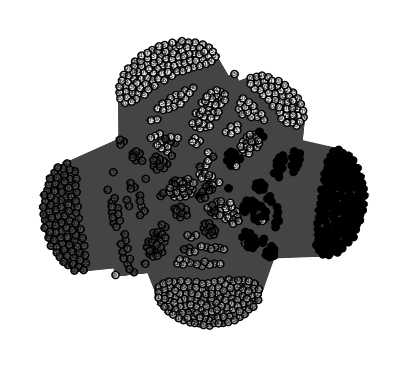

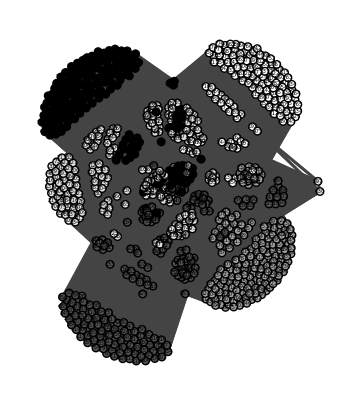

In [30]:
plotGraphWithClusterColors(g, res["OG"]["ML"], "OG" + "--" + "FG" + "BW")
plotGraphWithClusterColors(g, res["Linear"]["ML"], "Linear" + "--" + "FG" + "BW")

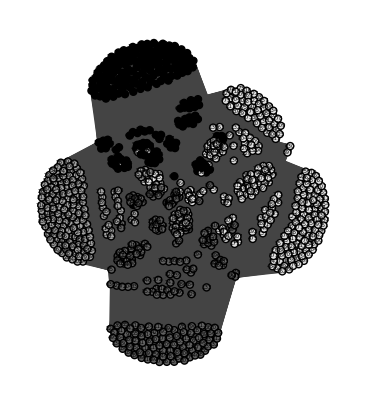

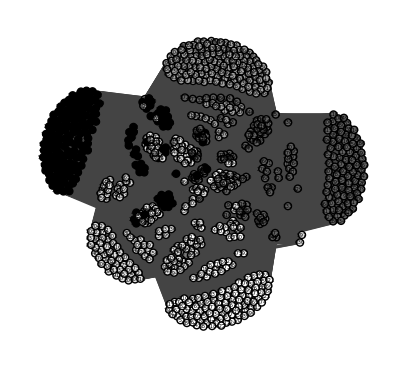

In [26]:
plotGraphWithClusterColors(g, res["OG"]["LE"], "OG" + "--" + "Multilevel" + "BW")
plotGraphWithClusterColors(g, res["Linear"]["LE"], "OG" + "--" + "Multilevel" + "BW")

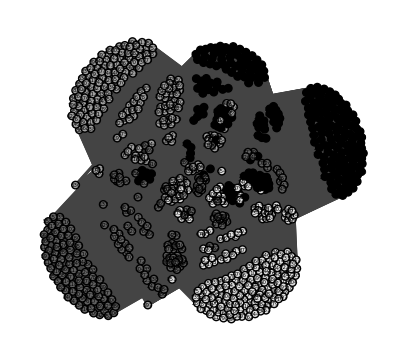

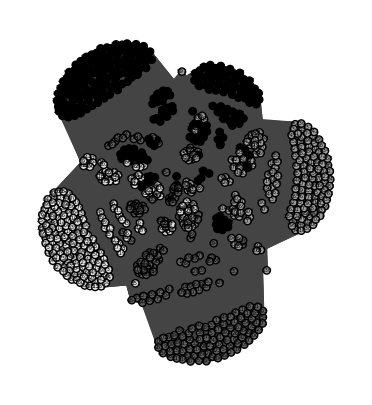

In [28]:
plotGraphWithClusterColors(g, res["OG"]["LE"], "OG" + "--" + "Multilevel" + "BW")
plotGraphWithClusterColors(g, res["Linear"]["LE"], "OG" + "--" + "Multilevel" + "BW")

In [24]:
for key in res:
    for alg in res[key]:
        print(alg + "--" + key)
        print(res[key][alg].summary())
        # plotGraphWithClusterColors(g, res[key][alg], alg + "--" + key + "BW")

IM--OG
Clustering with 882 elements and 1 clusters
LP--OG
Clustering with 882 elements and 1 clusters
FG--OG
Clustering with 882 elements and 4 clusters
LE--OG
Clustering with 882 elements and 4 clusters
L--OG
Clustering with 882 elements and 8 clusters
ML--OG
Clustering with 882 elements and 4 clusters
WT--OG
Clustering with 882 elements and 3 clusters
IM--Linear
Clustering with 882 elements and 1 clusters
LP--Linear
Clustering with 882 elements and 1 clusters
FG--Linear
Clustering with 882 elements and 3 clusters
LE--Linear
Clustering with 882 elements and 4 clusters
L--Linear
Clustering with 882 elements and 7 clusters
ML--Linear
Clustering with 882 elements and 5 clusters
WT--Linear
Clustering with 882 elements and 4 clusters


In [ ]:
plotGraphWithClusterColors(g, res["OG"]["FG"], "OG FG")
plotGraphWithClusterColors(g, res["Linear"]["FG"], "OG-25%Norm FG")